In [21]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time
import random
import scipy
import scipy.stats
import emcee
import corner

In [22]:
#file with data
file='./transient.npy'
data=np.load(file)

In [23]:
#saved data
t=data[:,0]
flux=data[:,1]
error=data[:,2]

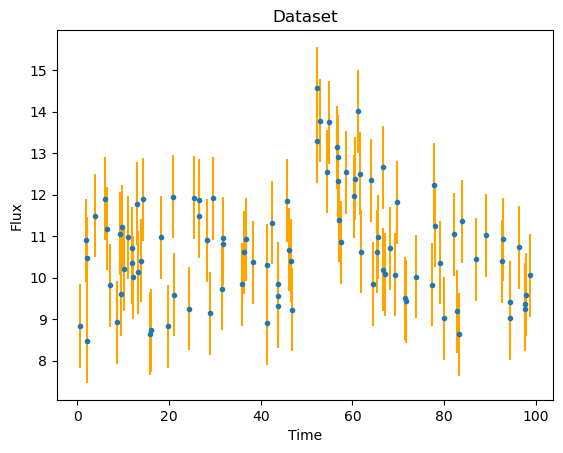

In [24]:
#plot for the dataset
plt.errorbar(t, flux, yerr=error, ecolor='orange', fmt='.')
plt.title('Dataset')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

In [25]:
#model for the data
def model(t1,b1,A1,t01,alpha1):
    m=[]
    for i in range(len(t1)):
        if t1[i]<t01:
            m.append(b1)
        if t1[i]>=t01:
            m.append(b1+A1*np.exp(-alpha1*(t1[i]-t01)))
    return m

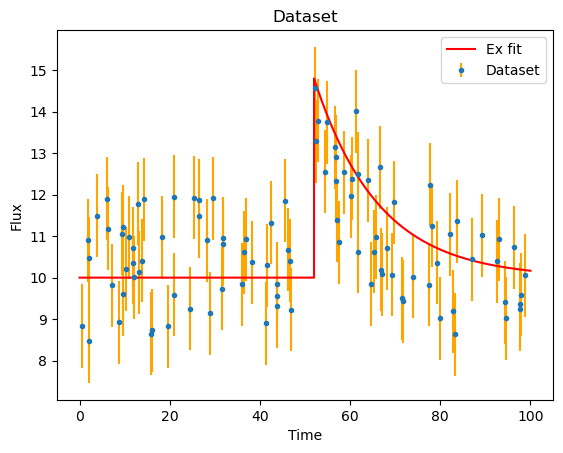

In [26]:
#first rough fit to have idea of parameters
plt.errorbar(t, flux, yerr=error, ecolor='orange', fmt='.',label='Dataset')
plt.plot(np.linspace(0,100,10000), model(np.linspace(0,100,10000), 10, 4.8, 52, 0.07), color='red', label='Ex fit')
plt.title('Dataset')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [27]:
def LogLikelihood(b, A, t0, alpha, error, flux, t):
    mod_y=np.array(model(t,b,A,t0,alpha))
    # Gaussian likelihood around the true value of the parameter
    return -0.5*np.sum(((np.array(flux)-mod_y)/error)**2)

def Prior(b,A,t0,alpha):
    #prior with uniform in parameters and uniform in logspace for alpha
    if (0<=b<=50)and(0<=A<=50)and(0<=t0<=100)and(-5<=np.log(alpha)<=5):
        return 1/alpha
    else:
        return 0

def myLogPosterior(par, error, flux, t):
    b, A, t0, alpha = par
    logposterior = np.log(Prior(b,A,t0,alpha))
    if not np.isfinite(logposterior):
        #if out of the pror space => return infinite value
        return -np.inf
    else:
        #if inside => log(sum the likelihood and the posterior)
        return LogLikelihood(b, A, t0, alpha, error, flux, t) + logposterior

In [28]:
ndim = 4 #number of parameters = number of dimention
nwalkers = 10 #number of walkers
nsteps = 10000 #n of steps of the chain

#initialize parameters 
np.random.seed(0)
init=np.ones((nwalkers,ndim))*[10, 4.8, 52, 0.07] 
starting_guesses = init+1e-3*np.random.random((nwalkers, ndim)) #important to add a little variation for walker

#function for the emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[error, flux, t])
sampler.run_mcmc(starting_guesses, nsteps)
print("done")

/tmp/ipykernel_2685/2478491572.py:8: RuntimeWarning: invalid value encountered in log
  if (0<=b<=50)and(0<=A<=50)and(0<=t0<=100)and(-5<=np.log(alpha)<=5):
/tmp/ipykernel_2685/2478491572.py:15: RuntimeWarning: divide by zero encountered in log
  logposterior = np.log(Prior(b,A,t0,alpha))


done


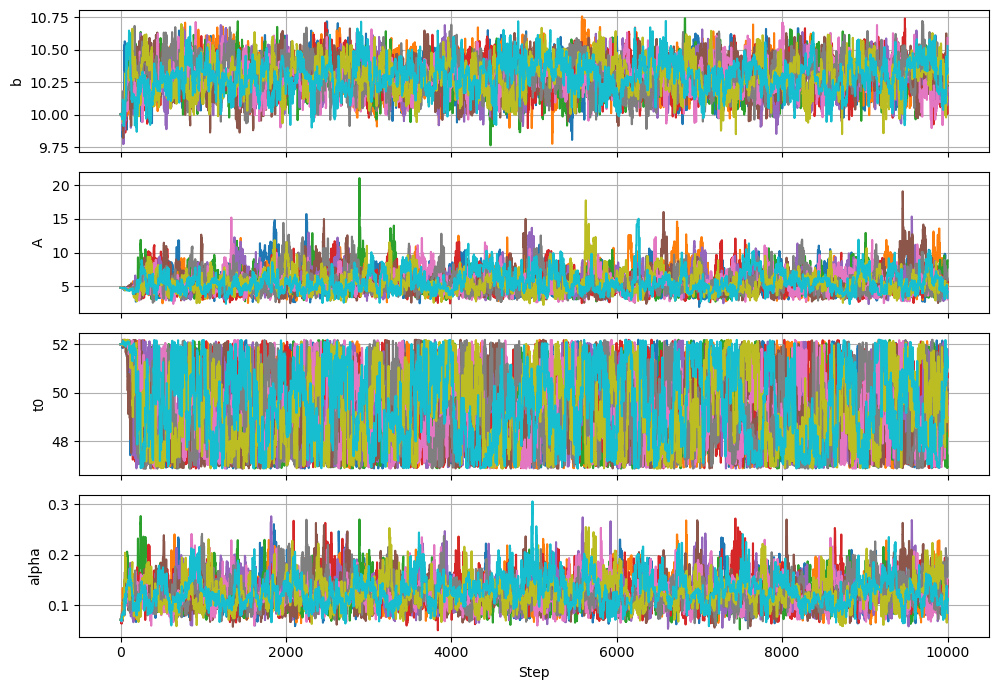

In [29]:
#take each chain
chain_all = sampler.get_chain()

#Plotting each parameter's chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["b", "A", "t0", "alpha"]  #Parameters

for i in range(ndim):
    ax = axes[i]
    ax.plot(chain_all[:,:, i])  #Plot chain for each walker
    ax.set_ylabel(labels[i])
    ax.grid()

axes[-1].set_xlabel("Step")
plt.tight_layout()
plt.show()

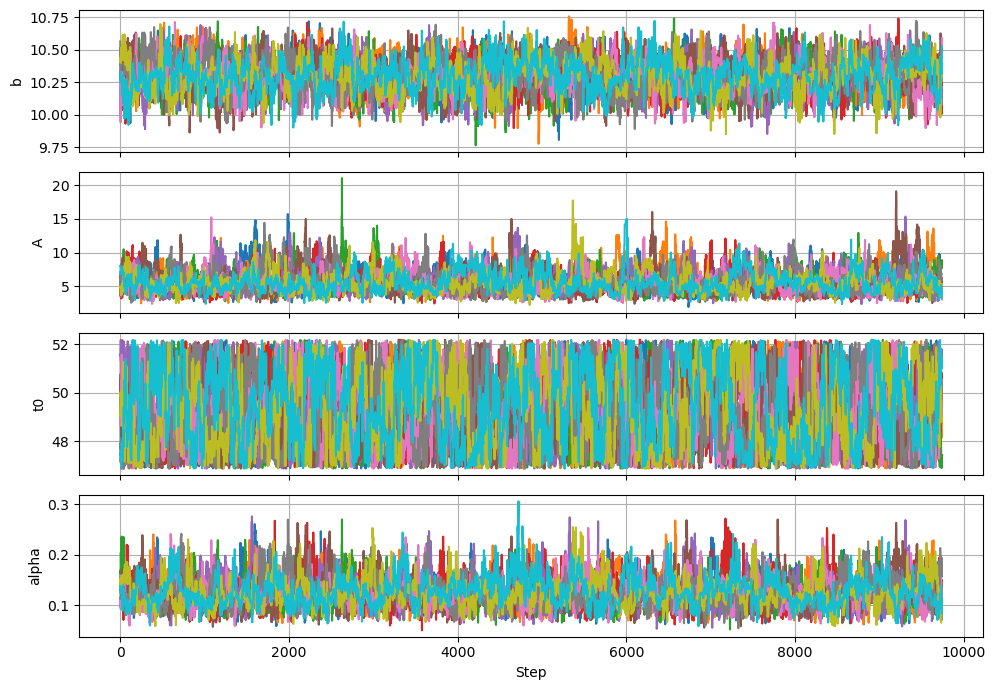

In [30]:
#take each chain post burn in
tau=sampler.get_autocorr_time(tol=0)
thin=int(np.max(tau))
burned=3*int(np.max(tau))

chain_notBurned = sampler.get_chain(discard=burned)

#Plotting each parameter's chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(chain_notBurned[:,:, i])  #Plot chain for each walker
    ax.set_ylabel(labels[i])
    ax.grid()

axes[-1].set_xlabel("Step")
plt.tight_layout()
plt.show()

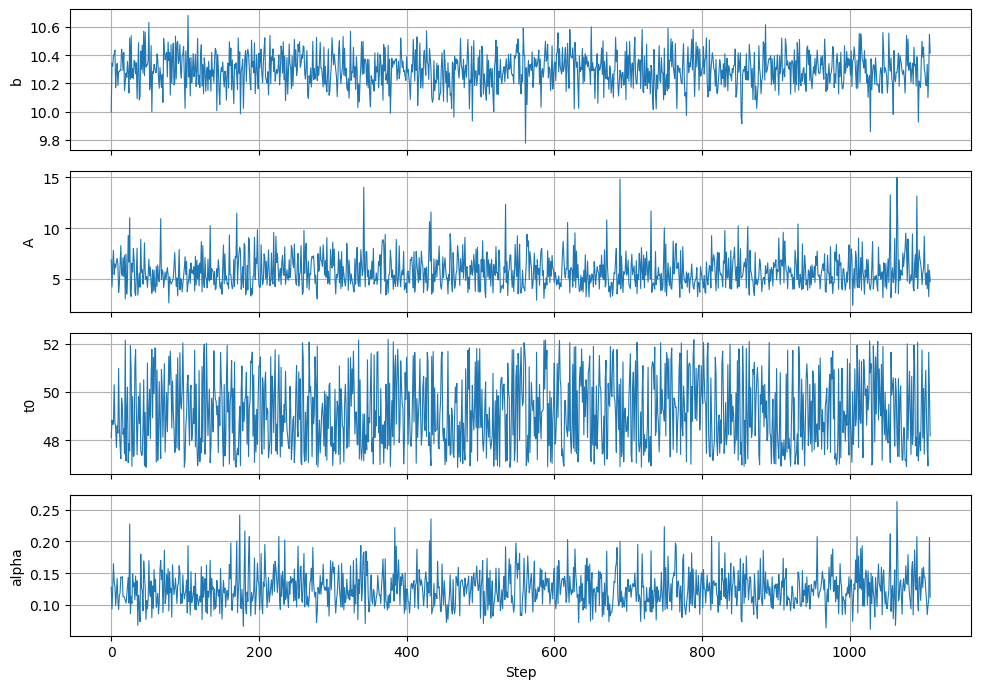

In [31]:
#take each chain post burn in and thinned + flatted
flat_chain=sampler.get_chain(discard=burned, thin=thin, flat=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

for i in range(4):
    ax = axes[i]
    ax.plot((flat_chain[:, i]), lw=0.8) #plot the flatten chain for all parameters
    ax.set_ylabel(labels[i])
    ax.grid()

axes[-1].set_xlabel("Step")
plt.tight_layout()
plt.show()

In [32]:
#mean values of the parameters
means=[]
for i in range(ndim):
    means.append(np.mean(flat_chain[:,i]))
    print(labels[i],': ',means[i])

b :  10.295823613331441
A :  5.735448832471028
t0 :  49.172018540001666
alpha :  0.12547155748846425


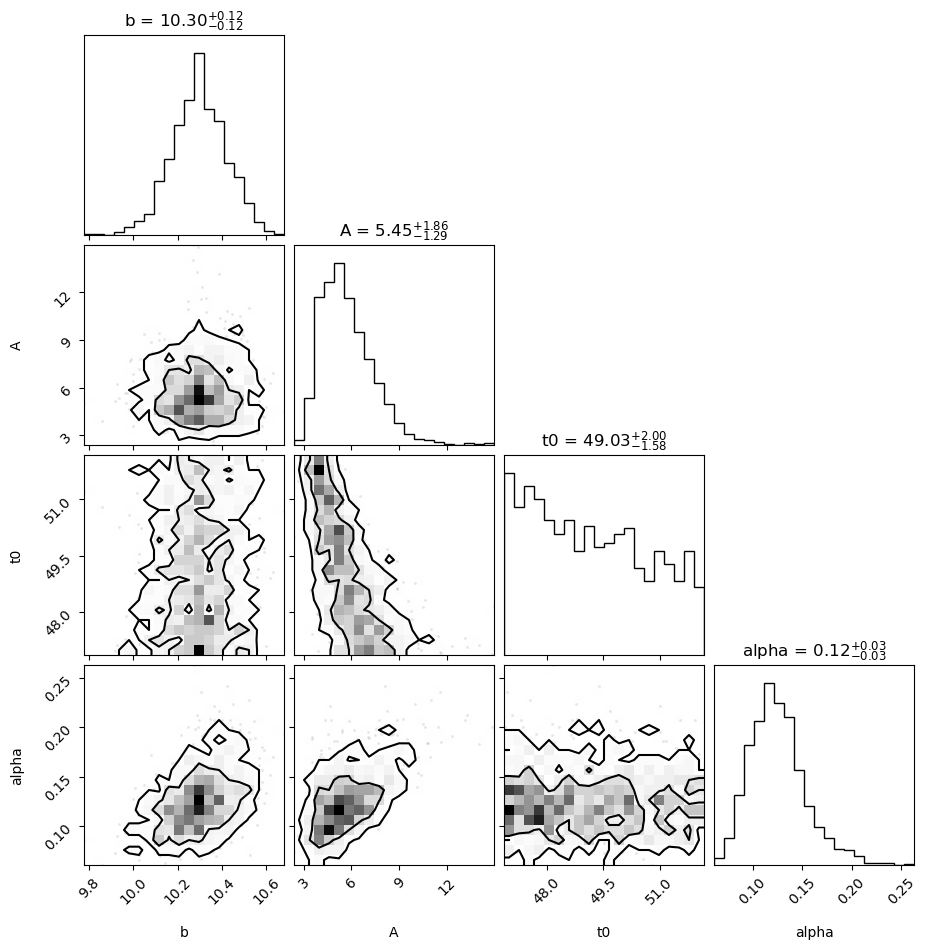

In [33]:
#corner plot
fig_corn = corner.corner(flat_chain, labels=labels, levels=[0.68,0.95], show_titles=True, title_fmt=".2f", plot_contours=True)

In [34]:
#take samples in the chain in burned part and not burned
Nsample=100

chain_onlyburned=[random.choice(sampler.get_chain(thin=thin, flat=True))[:burned] for i in range(Nsample)]
chain_sample=[random.choice(sampler.get_chain(discard=burned, thin=thin, flat=True)) for i in range(Nsample)]

In [35]:
#saving the parameters in the 2 regims
b_bur, A_bur, t0_bur, alpha_bur = [], [], [], []
b_s, A_s, t0_s, alpha_s = [], [], [], []

for i in range(0,Nsample):
    b_bur.append(chain_onlyburned[i][0])
    A_bur.append(chain_onlyburned[i][1])
    t0_bur.append(chain_onlyburned[i][2])
    alpha_bur.append(chain_onlyburned[i][3])

    b_s.append(chain_sample[i][0])
    A_s.append(chain_sample[i][1])
    t0_s.append(chain_sample[i][2])
    alpha_s.append(chain_sample[i][3])

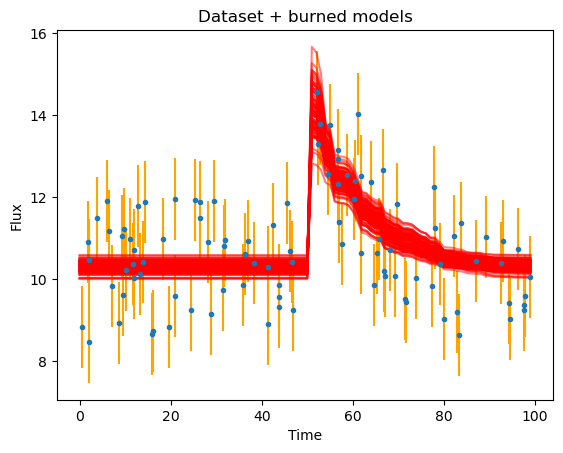

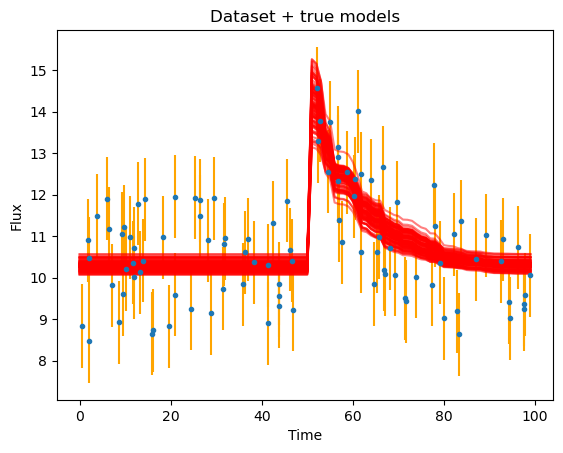

In [37]:
#plot of the models for the burned sample
plt.errorbar(t, flux, yerr=error, ecolor='orange', fmt='.')
   
for i in range(0, Nsample):
   plt.plot(model(t, b_bur[i], A_bur[i], t0_bur[i], alpha_bur[i]), color='red', alpha=0.5)

plt.title('Dataset + burned models')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

#plot of the models for the sample
plt.errorbar(t, flux, yerr=error, ecolor='orange', fmt='.')
   
for i in range(0, Nsample):
   plt.plot(model(t, b_s[i], A_s[i], t0_s[i], alpha_s[i]), color='red', alpha=0.5)

plt.title('Dataset + true models')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()